In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from utils.helpers import PATHS

In [2]:
# Get all
df = pd.read_csv(os.path.join(PATHS['root'], 'train_ship_segmentations_v2.csv'))

########## FETCHES AND CLEARS THE DATA ##########

# Corrupted images
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
            '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
            'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
            'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg']
# Remove corrupted file
df = df[~df['ImageId'].isin(exclude_list)]

# Count number of ships for each image
ship_count_df = df.copy()
ship_count_df["Counts"] = ship_count_df["EncodedPixels"].map(lambda x:1 if isinstance(x,str) else 0)
ship_count_df = ship_count_df.groupby("ImageId").agg({ "Counts":"sum" }).reset_index()

ship_count_df

,ImageId,Counts
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0
...,...,...
192550,fffedbb6b.jpg,0
192551,ffff2aa57.jpg,0
192552,ffff6e525.jpg,0
192553,ffffc50b4.jpg,0


,ImageId,EncodedPixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
2,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
3,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
4,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...,...,...
80614,fff909871.jpg,441057 2 441825 4 442592 7 443360 9 444128 11 ...
80615,fffcb6464.jpg,222782 4 223550 10 224318 14 225086 14 225854 ...
80616,fffd924fb.jpg,110011 5 110779 5 111547 5 112315 5 113083 5 1...
80617,fffd924fb.jpg,198440 8 199208 8 199976 8 200744 8 201512 8 2...


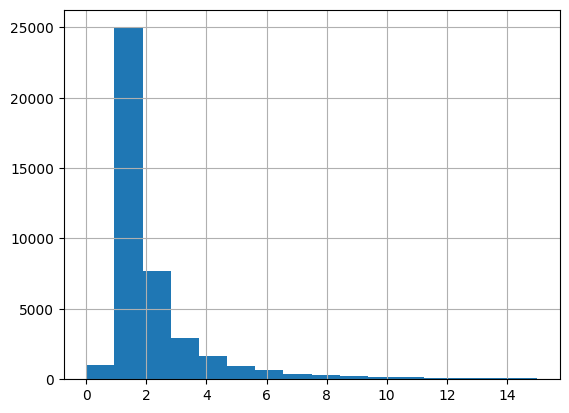

In [3]:
########## BALANCE DATASET ##########
# Keep max tot images for each class (e.g. 1000 images with 0 ships, 2000 images with 1 ship, ...)

def sample_fn(x):
    """
    Keep max MAX_SAMPLES_NO_SHIPS of images with no ships and
    max MAX_SAMPLES of images with ships (for each class)
    """

    MAX_SAMPLES_NO_SHIPS = 1000
    MAX_SAMPLES = 25000

    # Undersample no ships images by 1000
    if (x.Counts == 0).all():
        return x.sample(MAX_SAMPLES_NO_SHIPS) 
    # Undersample images with ships (limit number to MAX_SAMPLES)
    else:
        return x.sample(min(len(x), MAX_SAMPLES)) 


# Filter ImageIds based on the above critera (keep a max for each class)
ship_count_df = ship_count_df.groupby("Counts")[['ImageId', 'Counts']].apply(sample_fn).reset_index(drop=True)

# Filter the main df (that has bboxes, ...) to keep only the filtered ImageIds
balanced_df = df.merge(ship_count_df[["ImageId"]], how="inner", on="ImageId")

ship_count_df["Counts"].hist(bins=16)
balanced_df

In [ ]:
########## SPLIT DATASET ##########

# Split ImageIds into train and validation
train_ids, val_ids = train_test_split(ship_count_df, test_size=0.05, stratify=ship_count_df['Counts'], random_state=42)

# Filter the balanced_df into the two partitions
train_df = pd.merge(balanced_df, train_ids)
valid_df = pd.merge(balanced_df, val_ids)

print(train_df.head())

         ImageId                                      EncodedPixels  Counts
0  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...       1
1  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...       9
2  00021ddc3.jpg  101361 1 102128 3 102896 4 103663 6 104430 9 1...       9
3  00021ddc3.jpg  74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...       9
4  00021ddc3.jpg  74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...       9


,ImageId,Counts
16921,5b9301583.jpg,1
343,368663d6f.jpg,0
13592,51a098674.jpg,1
6450,e891dca31.jpg,1
9189,f1d8a0442.jpg,1
...,...,...
17371,fa245b71c.jpg,1
10439,c2498b4f7.jpg,1
2607,baca192dd.jpg,1
40849,4236073e2.jpg,10
